## 1. Install required packages

### 1.1. Initialize Wandb for training viualization (optional)

In [1]:
!pip install wandb

In [2]:
from tqdm.notebook import tqdm
from kaggle_secrets import UserSecretsClient
import wandb

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb_api_key")
wandb.login(key=my_secret)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
wandb.init(project="GAN_text_to_image", name="Running on Kaggle")

wandb: Currently logged in as: tien-thanh-info22. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240525_044921-pj38dxcp
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run Running on Kaggle
wandb: ⭐️ View project at https://wandb.ai/tien-thanh-info22/GAN_text_to_image
wandb: 🚀 View run at https://wandb.ai/tien-thanh-info22/GAN_text_to_image/runs/pj38dxcp/workspace


### 1.2. Install CLIP for text, image embedding

In [4]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xc7isvb3
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xc7isvb3
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... - done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=edf41c72a3f130f2ca359d57e7bed8b1590814a9671081e0df19783aa3f67d9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-h8iom_2q/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
import clip
clip_model, clip_preprocess = clip.load('ViT-B/32', device=device)

100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 43.3MiB/s]


### 1.3. Install torchmetrics for evaluation

In [7]:
!pip install torchmetrics
!pip install torch-fidelity

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

## 2. Import libraries

In [8]:
import os
import json
import re
import numpy as np
from PIL import Image

import warnings
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import Subset

import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt

## 3. Inspect COCO dataset

In [9]:
# Data paths
train_annotations = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json'
train_images_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
val_annotations = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json'
val_images_dir = '/kaggle/input/coco-2017-dataset/coco2017/val2017'
test_images_dir = '/kaggle/input/coco-2017-dataset/coco2017/test2017'

Image ID: 000000001993
Number of captions: 5
Image URL: /kaggle/input/coco-2017-dataset/coco2017/val2017/000000001993.jpg


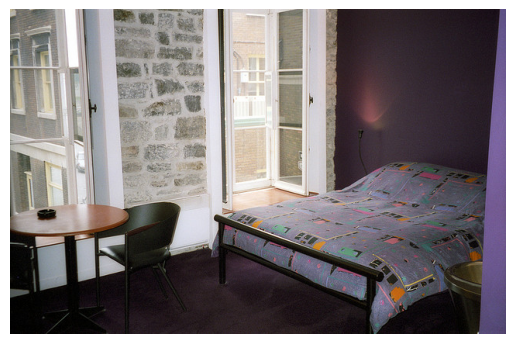

A bedroom with a bed and small table near by.
View of an apartment room with a bed an table and a view out the window.
A simple modern bedroom sheets on the bed
A bed room that has a table, chairs, and bed in it.
A room with purple walls, carpet and bed comforter.


In [10]:
def read_image_coco(image_id, image_dir):
    image_path = os.path.join(image_dir, f'{image_id:012d}.jpg')
    image = plt.imread(image_path)
    return image

def show_random_image_info(annotations_file, images_dir):
    with open(annotations_file, 'r') as f:
        annotations = json.load(f)
        
    random_annotation = annotations['annotations'][np.random.randint(len(annotations['annotations']))]
    image_id = random_annotation['image_id']
    image = read_image_coco(image_id, images_dir)
    captions = [annotation['caption'] for annotation in annotations['annotations'] if annotation['image_id'] == image_id]

    formatted_id = f'{image_id:012d}'
    image_path = os.path.join(images_dir, formatted_id + '.jpg')

    print(f"Image ID: {formatted_id}")
    print(f"Number of captions: {len(captions)}")
    print(f"Image URL: {image_path}")

    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    for caption in captions:
        print(caption)
       
    
show_random_image_info(val_annotations, val_images_dir)

In [11]:
print(f"Number of training images: {len(os.listdir(train_images_dir))}")
print(f"Number of validation images: {len(os.listdir(val_images_dir))}")
print(f"Number of test images: {len(os.listdir(test_images_dir))}")

Number of training images: 118287
Number of validation images: 5000
Number of test images: 40670


In [12]:
def calculate_caption_count_stats(train_annotations):
    with open(train_annotations, 'r') as f:
        annotations = json.load(f)

    image_caption_counts = {annotation['image_id']: 0 for annotation in annotations['annotations']}
    caption_lengths = []
    for annotation in annotations['annotations']:
        image_caption_counts[annotation['image_id']] += 1
        caption_lengths.append(len(annotation['caption']))

    caption_counts = list(image_caption_counts.values())
    caption_count_stats = {
        'mean': np.mean(caption_counts),
        'median': np.median(caption_counts),
        'min': np.min(caption_counts),
        'max': np.max(caption_counts),
        'avg_caption_length': np.mean(caption_lengths)
    }

    for stat, value in caption_count_stats.items():
        print(f"\t- {stat}: {value}")
        
print("Caption count per image statistics in training set:")
calculate_caption_count_stats(train_annotations)

print("\nCaption count per image statistics in validation set:")
calculate_caption_count_stats(val_annotations)

Caption count per image statistics in training set:
	- mean: 5.002688376575617
	- median: 5.0
	- min: 5
	- max: 7
	- avg_caption_length: 52.4888678215404

Caption count per image statistics in validation set:
	- mean: 5.0028
	- median: 5.0
	- min: 5
	- max: 7
	- avg_caption_length: 52.42028464060127


## 4. Create custom COCO dataset

In [13]:
class CustomCocoDataset(Dataset):
    def __init__(self, image_dir, annotations_file, transform=None):
        if not os.path.exists(annotations_file):
            raise ValueError(f"File annotations không tồn tại: {annotations_file}")

        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)

        self.image_dir = image_dir
        self.transform = transform if transform else ToTensor()

    def __len__(self):
        return len(self.annotations['annotations'])

    def __getitem__(self, idx):
        image_id = self.annotations['annotations'][idx]['image_id']
        image_path = os.path.join(self.image_dir, f'{image_id:012d}.jpg')
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption = self.annotations['annotations'][idx]['caption']
        caption = re.sub('[^A-Za-z0-9]+', ' ', caption)
        caption = caption.lower().strip()
        caption = caption.replace('.', '')
        return image, caption

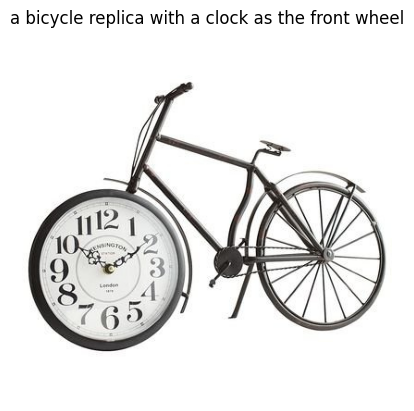

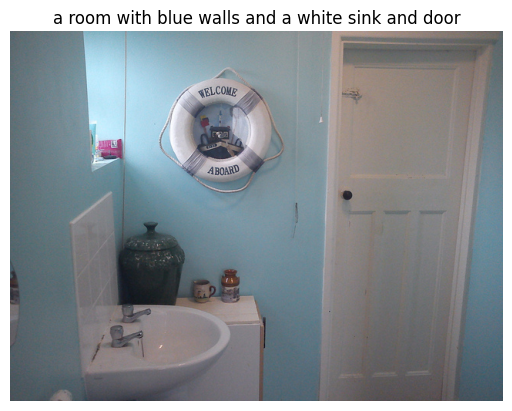

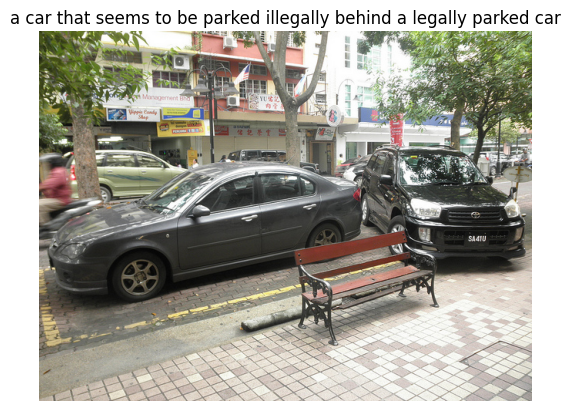

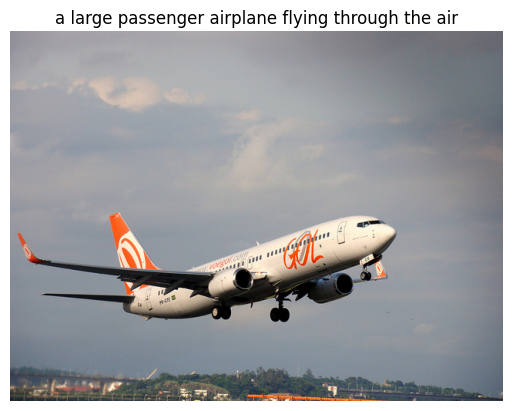

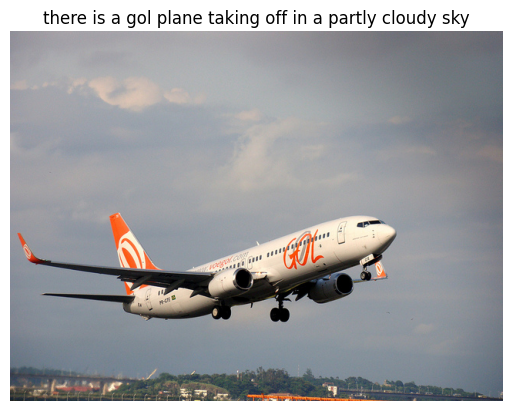

In [14]:
custom_coco_dataset = CustomCocoDataset(train_images_dir, train_annotations)

for i in range(5):
    image, caption = custom_coco_dataset[i]
    if image is None or caption is None:
        continue

    plt.imshow(image.permute(1, 2, 0))
    plt.title(caption)
    plt.axis('off')
    plt.show()    

## 5. Preprocess dataset and prepare data loader

### 5.1. Calculate mean and std for normalization

In [15]:
def calculate_mean_std(dataset, device):
    mean_sum = torch.tensor([0.0, 0.0, 0.0], device=device)
    std_sum = torch.tensor([0.0, 0.0, 0.0], device=device)
    n_samples = 0

    for img_tensor, _ in tqdm(dataset, desc='Calculating mean and std'):
        img_tensor = img_tensor.to(device)
        mean_sum += img_tensor.mean([-1, -2])
        std_sum += img_tensor.std([-1, -2])
        n_samples += 1

    mean = mean_sum / n_samples
    std = std_sum / n_samples

    return mean.cpu(), std.cpu()

train_dataset = CustomCocoDataset(train_images_dir, train_annotations, transform=transforms.ToTensor())

# mean, std = calculate_mean_std(train_dataset, device)

# print(f"Mean: {mean}, Std: {std}")

**Output:** <br>
Calculating mean and std: 100%|██████████| 591753/591753 [1:23:49<00:00, 117.65it/s] <br>
Mean: tensor([0.4700, 0.4468, 0.4076]), Std: tensor([0.2439, 0.2390, 0.2420])

### 5.2. Prepare data loader

In [16]:
from torch.utils.data import DataLoader
from torchvision import transforms

train_dataset = CustomCocoDataset(train_images_dir, train_annotations, transform=transforms.Compose([
    clip_preprocess,
]))

val_dataset = CustomCocoDataset(val_images_dir, val_annotations, transform=transforms.Compose([
    clip_preprocess,
]))

def collate_fn(batch):
    images, captions = zip(*batch)
    return torch.stack(images), captions  # Stack images, keep captions as list

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=12, collate_fn=collate_fn)

In [17]:
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")
print("\n")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")

Number of training batches: 18493
Number of validation batches: 782


Number of training images: 591753
Number of validation images: 25014


In [18]:
images, captions = next(iter(train_dataloader))
print(f"Shape of images in a batch: {images.shape}")

Shape of images in a batch: torch.Size([32, 3, 224, 224])


### 5.3. Subset data loader to a smaller size for debugging (optional)

In [19]:
def get_subset_dataloader(dataloader, subset_percent):
    num_samples = int(len(dataloader.dataset) * subset_percent)
    subset = Subset(dataloader.dataset, range(num_samples))
    subset_dataloader = DataLoader(subset, batch_size=dataloader.batch_size, collate_fn=dataloader.collate_fn)
    return subset_dataloader

# Get 10% of the original train and val DataLoaders
train_dataloader = get_subset_dataloader(train_dataloader, 0.03) # 0.1%
val_dataloader = get_subset_dataloader(val_dataloader, 0.03)

# Print the number of batches in the original and subset DataLoaders
print(f"Number of batches in the subset train DataLoader: {len(train_dataloader)}")
print(f"Number of batches in the subset val DataLoader: {len(val_dataloader)}")

Number of batches in the subset train DataLoader: 555
Number of batches in the subset val DataLoader: 24


In [20]:
print(f"Number of training images in subset: {len(train_dataloader) * train_dataloader.batch_size} images")
print(f"Number of validation images in subset: {len(val_dataloader) * val_dataloader.batch_size} images")

Number of training images in subset: 17760 images
Number of validation images in subset: 768 images


## 6. Build GAN model

### 6.2. Define model

In [21]:
import torch
import torch.nn as nn

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('ConvTranspose') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
            
# SpectralNorm implementation
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = nn.Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = nn.Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = nn.Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)
    
# Residual block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return F.relu(out)
    

# Self-attention block
# class SelfAttention(nn.Module):
#     def __init__(self, channels):
#         super(SelfAttention, self).__init__()
#         self.channels = channels
#         self.q_conv = nn.Conv2d(channels, channels // 8, 1, bias=False)
#         self.k_conv = nn.Conv2d(channels, channels // 8, 1, bias=False)
#         self.v_conv = nn.Conv2d(channels, channels, 1, bias=False)
#         self.gamma = nn.Parameter(torch.zeros(1))

#     def forward(self, x):
#         batch_size, _, height, width = x.size()
#         q = self.q_conv(x).view(batch_size, -1, height * width)
#         k = self.k_conv(x).view(batch_size, -1, height * width)
#         v = self.v_conv(x).view(batch_size, -1, height * width)

#         attention = torch.bmm(q.transpose(1, 2), k)
#         attention = F.softmax(attention, dim=2)

#         out = torch.bmm(v, attention.transpose(1, 2)).view(batch_size, -1, height, width)
#         out = self.gamma * out + x

#         return out
    
# class Generator(nn.Module):
#     def __init__(self, text_emb_size, img_size):
#         super(Generator, self).__init__()
#         self.fc = nn.Linear(text_emb_size, 512 * img_size // 16 * img_size // 16)
#         self.main = nn.Sequential(
#             nn.BatchNorm2d(512),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.ReLU(True),
#             SelfAttention(256),  # Thêm Self-Attention ở đây
#             ResBlock(256, 256),
#             nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.ReLU(True),
#             SelfAttention(128),  # Thêm Self-Attention ở đây
#             ResBlock(128, 128),
#             nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             SelfAttention(64),  # Thêm Self-Attention ở đây
#             ResBlock(64, 64),
#             nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
#             nn.Tanh()
#         )

#     def forward(self, text_emb):
#         x = self.fc(text_emb.float())
#         x = x.view(-1, 512, img_size // 16, img_size // 16)
#         return self.main(x)
            
# Generator model
class Generator(nn.Module):
    def __init__(self, text_emb_size, img_size):
        super(Generator, self).__init__()
        self.fc = nn.Linear(text_emb_size, 512 * img_size // 16 * img_size // 16)
        self.main = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            ResBlock(256, 256),  # Thêm ResBlock 
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            ResBlock(128, 128),  # Thêm ResBlock 
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            ResBlock(64, 64),  # Thêm ResBlock 
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, text_emb):
        x = self.fc(text_emb.float())
        x = x.view(-1, 512, img_size // 16, img_size // 16)
        return self.main(x)

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, img_size, text_emb_size):
        super(Discriminator, self).__init__()
        self.img_branch = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.text_branch = nn.Sequential(
            nn.Linear(text_emb_size, 256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.joint_conv = nn.Sequential(
            SpectralNorm(nn.Conv2d(512, 512, 1, 1, 0, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(512, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, img, text_emb):
        img_feat = self.img_branch(img)
        text_feat = self.text_branch(text_emb.float())
        text_feat = text_feat.unsqueeze(2).unsqueeze(3)
        text_feat = text_feat.expand(-1, -1, img_feat.size(2), img_feat.size(3))
        joint_feat = torch.cat([img_feat, text_feat], dim=1)
        output = self.joint_conv(joint_feat).view(-1)
        return output

# GAN model
class GAN(nn.Module):
    def __init__(self, text_emb_size, img_size):
        super(GAN, self).__init__()
        self.generator = Generator(text_emb_size, img_size)
        self.discriminator = Discriminator(img_size, text_emb_size)

        self.generator.apply(weights_init)
        self.discriminator.apply(weights_init)

    def forward(self, text_emb, img_size):
        fake_images = self.generator(text_emb, img_size)
        return fake_images
    
    
text_emb_size = 512
img_size = 224

gan = GAN(text_emb_size, img_size).to(device)

In [22]:
!pip install torchsummary

In [23]:
from torchsummary import summary

dummy_input = torch.randn(1, text_emb_size)

print("Summary of Generator:")
summary(gan.generator, dummy_input.size())

Summary of Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1, 100352]      51,480,576
       BatchNorm2d-2          [-1, 512, 14, 14]           1,024
              ReLU-3          [-1, 512, 14, 14]               0
   ConvTranspose2d-4          [-1, 256, 28, 28]       2,097,152
       BatchNorm2d-5          [-1, 256, 28, 28]             512
              ReLU-6          [-1, 256, 28, 28]               0
            Conv2d-7          [-1, 256, 28, 28]         590,080
       BatchNorm2d-8          [-1, 256, 28, 28]             512
            Conv2d-9          [-1, 256, 28, 28]         590,080
      BatchNorm2d-10          [-1, 256, 28, 28]             512
         ResBlock-11          [-1, 256, 28, 28]               0
  ConvTranspose2d-12          [-1, 128, 56, 56]         524,288
      BatchNorm2d-13          [-1, 128, 56, 56]             256
             ReLU

In [24]:
dummy_img_size = (3, img_size, img_size) 
dummy_text_emb_size = (text_emb_size,)

print("\nSummary of Discriminator's Image Branch:")
summary(gan.discriminator.img_branch, dummy_img_size)

print("\nSummary of Discriminator's Text Branch:")
summary(gan.discriminator.text_branch, dummy_text_emb_size)


Summary of Discriminator's Image Branch:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,072
         LeakyReLU-2         [-1, 64, 112, 112]               0
      SpectralNorm-3          [-1, 128, 56, 56]               0
         LeakyReLU-4          [-1, 128, 56, 56]               0
      SpectralNorm-5          [-1, 256, 28, 28]               0
         LeakyReLU-6          [-1, 256, 28, 28]               0
Total params: 3,072
Trainable params: 3,072
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 21.44
Params size (MB): 0.01
Estimated Total Size (MB): 22.02
----------------------------------------------------------------

Summary of Discriminator's Text Branch:
----------------------------------------------------------------
        Layer (type)    

### 6.4. Model training

In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Optimizer
optim_disc = torch.optim.Adam(gan.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optim_gen = torch.optim.Adam(gan.generator.parameters(), lr=0.0004, betas=(0.5, 0.999))

# Schedulers
scheduler_gen = ReduceLROnPlateau(optim_gen, mode='min', factor=0.5, patience=10, verbose=True)
scheduler_disc = ReduceLROnPlateau(optim_disc, mode='min', factor=0.5, patience=10, verbose=True)

# Hàm mất mát
adversarial_loss = torch.nn.BCELoss()
clip_loss = torch.nn.L1Loss()

# Số lượng epochs huấn luyện
num_epochs = 60

# Lưu trữ lịch sử loss cho việc plot
gen_train_losses = []
disc_train_losses = []
gen_val_losses = []
disc_val_losses = []
fid_scores = []
is_scores = []

# Khởi tạo metric
fid_metric = FrechetInceptionDistance(feature=2048).to(device)
is_metric = InceptionScore().to(device)
best_fid = float('inf')

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 268MB/s]


In [26]:
for epoch in range(num_epochs):
    # Training loop
    gen_train_loss = 0.0
    disc_train_loss = 0.0
    for batch_idx, (images, captions) in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        real_images = images.to(device)
        real_image_features = clip_model.encode_image(real_images).to(device)
        text_embeddings = clip_model.encode_text(clip.tokenize(captions).to(device)).to(device)

        # ===== Huấn luyện Discriminator =====
        optim_disc.zero_grad()

        with torch.no_grad():
            fake_images = gan.generator(text_embeddings).to(device)
            fake_image_features = clip_model.encode_image(fake_images).to(device)

        # Tính logits cho ảnh thật và ảnh giả
        real_logits = gan.discriminator(real_images, text_embeddings)
        fake_logits = gan.discriminator(fake_images.detach(), text_embeddings)

        # Tính toán mất mát adversarial cho Discriminator
        disc_real_loss = adversarial_loss(real_logits, torch.ones_like(real_logits, device=device))
        disc_fake_loss = adversarial_loss(fake_logits, torch.zeros_like(fake_logits, device=device))
        disc_loss = (disc_real_loss + disc_fake_loss) / 2
        disc_train_loss += disc_loss.item()

        disc_loss.backward(retain_graph=True)
        optim_disc.step()

        # ===== Huấn luyện Generator =====
        optim_gen.zero_grad()

        fake_images = gan.generator(text_embeddings)
        fake_image_features = clip_model.encode_image(fake_images)

        # Tính logits cho ảnh giả
        fake_logits = gan.discriminator(fake_images, text_embeddings)

        # Tính toán mất mất adversarial cho Generator
        gen_adversarial_loss = adversarial_loss(fake_logits, torch.ones_like(fake_logits, device=device))

        # Tính toán mất mất CLIP cho Generator
        clip_loss_value = clip_loss(fake_image_features, real_image_features)

        # Tổng mất mất cho Generator
        gen_loss = gen_adversarial_loss + clip_loss_value
        gen_train_loss += gen_loss.item()

        gen_loss.backward()
        optim_gen.step()

    # Calculate average training losses
    gen_train_loss /= len(train_dataloader)
    disc_train_loss /= len(train_dataloader)

    # Evaluation loop
    gen_val_loss = 0.0
    disc_val_loss = 0.0
    
    real_images_for_fid = []
    fake_images_for_fid = []
    
    with torch.no_grad():
        for val_batch_idx, (val_images, val_captions) in enumerate(tqdm(val_dataloader, desc='Validation')):
            val_real_images = val_images.to(device)
            val_real_image_features = clip_model.encode_image(val_real_images).to(device)
            val_text_embeddings = clip_model.encode_text(clip.tokenize(val_captions).to(device)).to(device)
            
            # Evaluate Discriminator
            val_fake_images = gan.generator(val_text_embeddings).to(device)
            val_fake_image_features = clip_model.encode_image(val_fake_images).to(device)
            
            real_images_for_fid.append(val_real_images)
            fake_images_for_fid.append(val_fake_images)

            # Tính logits cho ảnh thật và ảnh giả
            val_real_logits = gan.discriminator(val_real_images, val_text_embeddings)
            val_fake_logits = gan.discriminator(val_fake_images, val_text_embeddings)

            # Tính toán mất mát adversarial cho Discriminator
            val_disc_real_loss = adversarial_loss(val_real_logits, torch.ones_like(val_real_logits, device=device))
            val_disc_fake_loss = adversarial_loss(val_fake_logits, torch.zeros_like(val_fake_logits, device=device))
            val_disc_loss = (val_disc_real_loss + val_disc_fake_loss) / 2
            disc_val_loss += val_disc_loss.item()

            # Evaluate Generator
            val_fake_logits = gan.discriminator(val_fake_images, val_text_embeddings)

            # Tính toán mất mất adversarial cho Generator
            val_gen_adversarial_loss = adversarial_loss(val_fake_logits, torch.ones_like(val_fake_logits, device=device))

            # Tính toán mất mất CLIP cho Generator
            val_clip_loss_value = clip_loss(val_fake_image_features, val_real_image_features)

            # Tổng mất mất cho Generator
            val_gen_loss = val_gen_adversarial_loss + val_clip_loss_value
            gen_val_loss += val_gen_loss.item()
            
    # Calculate average validation losses
    disc_val_loss /= len(val_dataloader)
    gen_val_loss /= len(val_dataloader)

    # Save losses
    gen_train_losses.append(gen_train_loss)
    disc_train_losses.append(disc_train_loss)
    gen_val_losses.append(gen_val_loss)
    disc_val_losses.append(disc_val_loss)
    

    # Combine the list of tensors into a single tensor
    real_images_for_fid = torch.cat(real_images_for_fid, dim=0)
    fake_images_for_fid = torch.cat(fake_images_for_fid, dim=0)

    # Compute FID
    real_images_for_fid = torch.clamp(real_images_for_fid, 0, 1)
    fake_images_for_fid = torch.clamp(fake_images_for_fid, 0, 1)
    real_images_for_fid = (real_images_for_fid * 255).to(torch.uint8)
    fake_images_for_fid = (fake_images_for_fid * 255).to(torch.uint8)
    fid_metric.update(real_images_for_fid, real=True)
    fid_metric.update(fake_images_for_fid, real=False)
    fid_score = fid_metric.compute()
    fid_metric.reset()
    fid_scores.append(fid_score)

    # Compute IS
    is_metric.update(fake_images_for_fid)
    is_score, is_std = is_metric.compute()
    is_metric.reset()
    is_scores.append(is_score)

    # Print training and validation losses
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Discriminator Loss: {disc_train_loss:.4f}, Training Generator Loss: {gen_train_loss:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Discriminator Loss: {disc_val_loss:.4f}, Validation Generator Loss: {gen_val_loss:.4f}')
    
    if fid_score < best_fid:
        best_fid = fid_score
        print(f'New best FID score: {best_fid:.4f}')
        torch.save(gan.state_dict(), 'GAN_txt2img_model.pth')
    else:
        print(f'FID score: {fid_score:.4f}')
    print(f'Inception Score: {is_score:.4f}')
    
    scheduler_gen.step(gen_val_loss)
    scheduler_disc.step(disc_val_loss)
    
    torch.cuda.empty_cache()
        
    wandb.log({
        "gen_train_loss": gen_train_loss,
        "disc_train_loss": disc_train_loss,
        "gen_val_loss": gen_val_loss,
        "disc_val_loss": disc_val_loss,
        "gen_lr": optim_gen.param_groups[0]['lr'],
        "disc_lr": optim_disc.param_groups[0]['lr'],
        "fid_score": fid_score,
        "is_score": is_score
    })

print('\nTraining completed!')
print(f'Save model at best FID score: {best_fid:.4f}')

Validation: 100%|██████████| 24/24 [00:13<00:00,  1.75it/s]


Epoch [1/60], Training Discriminator Loss: 0.5840, Training Generator Loss: 1.1799
Epoch [1/60], Validation Discriminator Loss: 0.5412, Validation Generator Loss: 1.1694
New best FID score: 430.8784
Inception Score: 2.1758


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]


Epoch [2/60], Training Discriminator Loss: 0.4997, Training Generator Loss: 1.2888
Epoch [2/60], Validation Discriminator Loss: 0.4867, Validation Generator Loss: 1.2625
New best FID score: 353.0316
Inception Score: 1.9878


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


Epoch [3/60], Training Discriminator Loss: 0.4659, Training Generator Loss: 1.3496
Epoch [3/60], Validation Discriminator Loss: 0.5982, Validation Generator Loss: 1.0729
FID score: 354.0960
Inception Score: 1.8907


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


Epoch [4/60], Training Discriminator Loss: 0.4465, Training Generator Loss: 1.3915
Epoch [4/60], Validation Discriminator Loss: 0.4396, Validation Generator Loss: 1.3155
New best FID score: 330.3189
Inception Score: 2.1693


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


Epoch [5/60], Training Discriminator Loss: 0.4225, Training Generator Loss: 1.4457
Epoch [5/60], Validation Discriminator Loss: 0.4434, Validation Generator Loss: 1.5130
New best FID score: 325.4936
Inception Score: 2.1174


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]


Epoch [6/60], Training Discriminator Loss: 0.4090, Training Generator Loss: 1.4802
Epoch [6/60], Validation Discriminator Loss: 0.4175, Validation Generator Loss: 1.4648
FID score: 328.1624
Inception Score: 2.0717


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


Epoch [7/60], Training Discriminator Loss: 0.3968, Training Generator Loss: 1.5129
Epoch [7/60], Validation Discriminator Loss: 0.4421, Validation Generator Loss: 1.6731
FID score: 341.2090
Inception Score: 2.0423


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]


Epoch [8/60], Training Discriminator Loss: 0.3884, Training Generator Loss: 1.5357
Epoch [8/60], Validation Discriminator Loss: 0.3916, Validation Generator Loss: 1.4885
FID score: 352.5630
Inception Score: 1.8990


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]


Epoch [9/60], Training Discriminator Loss: 0.3801, Training Generator Loss: 1.5623
Epoch [9/60], Validation Discriminator Loss: 0.3910, Validation Generator Loss: 1.5738
FID score: 341.6946
Inception Score: 2.0443


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]


Epoch [10/60], Training Discriminator Loss: 0.3736, Training Generator Loss: 1.5820
Epoch [10/60], Validation Discriminator Loss: 0.3821, Validation Generator Loss: 1.6050
New best FID score: 322.2354
Inception Score: 2.0058


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


Epoch [11/60], Training Discriminator Loss: 0.3649, Training Generator Loss: 1.6042
Epoch [11/60], Validation Discriminator Loss: 0.3858, Validation Generator Loss: 1.6823
New best FID score: 316.6026
Inception Score: 1.9872


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]


Epoch [12/60], Training Discriminator Loss: 0.3607, Training Generator Loss: 1.6209
Epoch [12/60], Validation Discriminator Loss: 0.3922, Validation Generator Loss: 1.5039
FID score: 321.0886
Inception Score: 2.0692


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]


Epoch [13/60], Training Discriminator Loss: 0.3532, Training Generator Loss: 1.6395
Epoch [13/60], Validation Discriminator Loss: 0.3630, Validation Generator Loss: 1.6311
FID score: 320.8227
Inception Score: 2.1055


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]


Epoch [14/60], Training Discriminator Loss: 0.3493, Training Generator Loss: 1.6546
Epoch [14/60], Validation Discriminator Loss: 0.3821, Validation Generator Loss: 1.7687
New best FID score: 309.6040
Inception Score: 2.1595
Epoch 00014: reducing learning rate of group 0 to 2.0000e-04.


Validation: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s]


Epoch [15/60], Training Discriminator Loss: 0.3443, Training Generator Loss: 1.6627
Epoch [15/60], Validation Discriminator Loss: 0.3696, Validation Generator Loss: 1.6759
FID score: 327.6446
Inception Score: 2.1996


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]


Epoch [16/60], Training Discriminator Loss: 0.3396, Training Generator Loss: 1.6762
Epoch [16/60], Validation Discriminator Loss: 0.3530, Validation Generator Loss: 1.5580
FID score: 328.6176
Inception Score: 2.1728


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


Epoch [17/60], Training Discriminator Loss: 0.3351, Training Generator Loss: 1.6872
Epoch [17/60], Validation Discriminator Loss: 0.3474, Validation Generator Loss: 1.6827
FID score: 328.3428
Inception Score: 2.2505


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]


Epoch [18/60], Training Discriminator Loss: 0.3312, Training Generator Loss: 1.7009
Epoch [18/60], Validation Discriminator Loss: 0.3491, Validation Generator Loss: 1.4584
FID score: 331.3073
Inception Score: 2.2516


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.06it/s]


Epoch [19/60], Training Discriminator Loss: 0.3274, Training Generator Loss: 1.7149
Epoch [19/60], Validation Discriminator Loss: 0.3441, Validation Generator Loss: 1.7179
FID score: 333.0037
Inception Score: 2.3335


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


Epoch [20/60], Training Discriminator Loss: 0.3235, Training Generator Loss: 1.7268
Epoch [20/60], Validation Discriminator Loss: 0.3450, Validation Generator Loss: 1.5094
FID score: 333.0038
Inception Score: 2.3060


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.00it/s]


Epoch [21/60], Training Discriminator Loss: 0.3195, Training Generator Loss: 1.7385
Epoch [21/60], Validation Discriminator Loss: 0.3329, Validation Generator Loss: 1.7354
FID score: 323.6941
Inception Score: 2.3933


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


Epoch [22/60], Training Discriminator Loss: 0.3189, Training Generator Loss: 1.7464
Epoch [22/60], Validation Discriminator Loss: 0.3278, Validation Generator Loss: 1.6401
FID score: 324.5676
Inception Score: 2.3348


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]


Epoch [23/60], Training Discriminator Loss: 0.3140, Training Generator Loss: 1.7597
Epoch [23/60], Validation Discriminator Loss: 0.3750, Validation Generator Loss: 1.2398
FID score: 327.0113
Inception Score: 2.2479


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]


Epoch [24/60], Training Discriminator Loss: 0.3116, Training Generator Loss: 1.7697
Epoch [24/60], Validation Discriminator Loss: 0.3226, Validation Generator Loss: 1.6783
FID score: 328.2043
Inception Score: 2.4482


Validation: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s]


Epoch [25/60], Training Discriminator Loss: 0.3104, Training Generator Loss: 1.7773
Epoch [25/60], Validation Discriminator Loss: 0.3241, Validation Generator Loss: 1.6183
FID score: 326.7102
Inception Score: 2.3992
Epoch 00025: reducing learning rate of group 0 to 1.0000e-04.


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


Epoch [26/60], Training Discriminator Loss: 0.3074, Training Generator Loss: 1.7842
Epoch [26/60], Validation Discriminator Loss: 0.3423, Validation Generator Loss: 1.8179
FID score: 324.8750
Inception Score: 2.4362


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]


Epoch [27/60], Training Discriminator Loss: 0.3029, Training Generator Loss: 1.7936
Epoch [27/60], Validation Discriminator Loss: 0.3309, Validation Generator Loss: 1.5944
FID score: 332.1998
Inception Score: 2.5016


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


Epoch [28/60], Training Discriminator Loss: 0.3025, Training Generator Loss: 1.8010
Epoch [28/60], Validation Discriminator Loss: 0.3644, Validation Generator Loss: 1.8845
FID score: 327.4360
Inception Score: 2.4890


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]


Epoch [29/60], Training Discriminator Loss: 0.2982, Training Generator Loss: 1.8121
Epoch [29/60], Validation Discriminator Loss: 0.3288, Validation Generator Loss: 1.8982
FID score: 325.0054
Inception Score: 2.5691


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]


Epoch [30/60], Training Discriminator Loss: 0.2975, Training Generator Loss: 1.8173
Epoch [30/60], Validation Discriminator Loss: 0.3109, Validation Generator Loss: 1.7035
FID score: 324.8930
Inception Score: 2.5444


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]


Epoch [31/60], Training Discriminator Loss: 0.2936, Training Generator Loss: 1.8313
Epoch [31/60], Validation Discriminator Loss: 0.3454, Validation Generator Loss: 1.9270
FID score: 327.9580
Inception Score: 2.5794


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]


Epoch [32/60], Training Discriminator Loss: 0.2934, Training Generator Loss: 1.8352
Epoch [32/60], Validation Discriminator Loss: 0.3173, Validation Generator Loss: 1.5304
FID score: 323.2750
Inception Score: 2.5140


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


Epoch [33/60], Training Discriminator Loss: 0.2904, Training Generator Loss: 1.8499
Epoch [33/60], Validation Discriminator Loss: 0.3154, Validation Generator Loss: 1.6488
FID score: 326.2317
Inception Score: 2.4127


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]


Epoch [34/60], Training Discriminator Loss: 0.2878, Training Generator Loss: 1.8576
Epoch [34/60], Validation Discriminator Loss: 0.3090, Validation Generator Loss: 1.6410
FID score: 325.8075
Inception Score: 2.5301


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


Epoch [35/60], Training Discriminator Loss: 0.2865, Training Generator Loss: 1.8645
Epoch [35/60], Validation Discriminator Loss: 0.3029, Validation Generator Loss: 1.6751
FID score: 323.2683
Inception Score: 2.5432


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]


Epoch [36/60], Training Discriminator Loss: 0.2859, Training Generator Loss: 1.8709
Epoch [36/60], Validation Discriminator Loss: 0.3058, Validation Generator Loss: 1.7441
FID score: 320.7705
Inception Score: 2.5447
Epoch 00036: reducing learning rate of group 0 to 5.0000e-05.


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]


Epoch [37/60], Training Discriminator Loss: 0.2814, Training Generator Loss: 1.8818
Epoch [37/60], Validation Discriminator Loss: 0.3010, Validation Generator Loss: 1.7632
FID score: 320.8794
Inception Score: 2.5429


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]


Epoch [38/60], Training Discriminator Loss: 0.2816, Training Generator Loss: 1.8807
Epoch [38/60], Validation Discriminator Loss: 0.3009, Validation Generator Loss: 1.7721
FID score: 320.2188
Inception Score: 2.6121


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]


Epoch [39/60], Training Discriminator Loss: 0.2795, Training Generator Loss: 1.8926
Epoch [39/60], Validation Discriminator Loss: 0.3098, Validation Generator Loss: 1.6647
FID score: 322.7275
Inception Score: 2.5782


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


Epoch [40/60], Training Discriminator Loss: 0.2775, Training Generator Loss: 1.8975
Epoch [40/60], Validation Discriminator Loss: 0.3178, Validation Generator Loss: 1.4714
FID score: 317.4260
Inception Score: 2.6423


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]


Epoch [41/60], Training Discriminator Loss: 0.2759, Training Generator Loss: 1.9082
Epoch [41/60], Validation Discriminator Loss: 0.3067, Validation Generator Loss: 1.5373
FID score: 316.3579
Inception Score: 2.6562


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]


Epoch [42/60], Training Discriminator Loss: 0.2737, Training Generator Loss: 1.9143
Epoch [42/60], Validation Discriminator Loss: 0.3452, Validation Generator Loss: 2.1068
FID score: 313.6005
Inception Score: 2.6576


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


Epoch [43/60], Training Discriminator Loss: 0.2766, Training Generator Loss: 1.9172
Epoch [43/60], Validation Discriminator Loss: 0.3647, Validation Generator Loss: 1.4181
FID score: 318.4930
Inception Score: 2.6243


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]


Epoch [44/60], Training Discriminator Loss: 0.2738, Training Generator Loss: 1.9167
Epoch [44/60], Validation Discriminator Loss: 0.2921, Validation Generator Loss: 1.6931
FID score: 312.0544
Inception Score: 2.6453


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


Epoch [45/60], Training Discriminator Loss: 0.2698, Training Generator Loss: 1.9353
Epoch [45/60], Validation Discriminator Loss: 0.3030, Validation Generator Loss: 1.5785
FID score: 311.4687
Inception Score: 2.6639


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


Epoch [46/60], Training Discriminator Loss: 0.2698, Training Generator Loss: 1.9417
Epoch [46/60], Validation Discriminator Loss: 0.3059, Validation Generator Loss: 1.6295
FID score: 313.9096
Inception Score: 2.6096


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s]


Epoch [47/60], Training Discriminator Loss: 0.2684, Training Generator Loss: 1.9481
Epoch [47/60], Validation Discriminator Loss: 0.2877, Validation Generator Loss: 1.7149
FID score: 310.0428
Inception Score: 2.7087
Epoch 00047: reducing learning rate of group 0 to 2.5000e-05.


Validation: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s]


Epoch [48/60], Training Discriminator Loss: 0.2656, Training Generator Loss: 1.9551
Epoch [48/60], Validation Discriminator Loss: 0.3003, Validation Generator Loss: 1.5330
FID score: 310.6570
Inception Score: 2.7508


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]


Epoch [49/60], Training Discriminator Loss: 0.2673, Training Generator Loss: 1.9560
Epoch [49/60], Validation Discriminator Loss: 0.2972, Validation Generator Loss: 1.5488
FID score: 311.2599
Inception Score: 2.7931


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


Epoch [50/60], Training Discriminator Loss: 0.2641, Training Generator Loss: 1.9661
Epoch [50/60], Validation Discriminator Loss: 0.2929, Validation Generator Loss: 1.5923
FID score: 310.5940
Inception Score: 2.7635


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


Epoch [51/60], Training Discriminator Loss: 0.2623, Training Generator Loss: 1.9746
Epoch [51/60], Validation Discriminator Loss: 0.3549, Validation Generator Loss: 1.3816
FID score: 310.8195
Inception Score: 2.7298


Validation: 100%|██████████| 24/24 [00:12<00:00,  2.00it/s]


Epoch [52/60], Training Discriminator Loss: 0.2608, Training Generator Loss: 1.9796
Epoch [52/60], Validation Discriminator Loss: 0.3421, Validation Generator Loss: 1.9995
FID score: 310.7585
Inception Score: 2.7551


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]


Epoch [53/60], Training Discriminator Loss: 0.2608, Training Generator Loss: 1.9900
Epoch [53/60], Validation Discriminator Loss: 0.3278, Validation Generator Loss: 1.4413
FID score: 311.2209
Inception Score: 2.7658


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.87it/s]


Epoch [54/60], Training Discriminator Loss: 0.2586, Training Generator Loss: 1.9916
Epoch [54/60], Validation Discriminator Loss: 0.2786, Validation Generator Loss: 1.8224
New best FID score: 309.3873
Inception Score: 2.7740


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


Epoch [55/60], Training Discriminator Loss: 0.2579, Training Generator Loss: 2.0013
Epoch [55/60], Validation Discriminator Loss: 0.2891, Validation Generator Loss: 1.6620
FID score: 310.1960
Inception Score: 2.8040


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


Epoch [56/60], Training Discriminator Loss: 0.2569, Training Generator Loss: 2.0052
Epoch [56/60], Validation Discriminator Loss: 0.2848, Validation Generator Loss: 1.6583
New best FID score: 308.0335
Inception Score: 2.7382


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


Epoch [57/60], Training Discriminator Loss: 0.2551, Training Generator Loss: 2.0138
Epoch [57/60], Validation Discriminator Loss: 0.2827, Validation Generator Loss: 1.8697
New best FID score: 307.6734
Inception Score: 2.7609


Validation: 100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


Epoch [58/60], Training Discriminator Loss: 0.2574, Training Generator Loss: 2.0147
Epoch [58/60], Validation Discriminator Loss: 0.2907, Validation Generator Loss: 1.6618
New best FID score: 307.6694
Inception Score: 2.7193
Epoch 00058: reducing learning rate of group 0 to 1.2500e-05.


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


Epoch [59/60], Training Discriminator Loss: 0.2520, Training Generator Loss: 2.0269
Epoch [59/60], Validation Discriminator Loss: 0.2802, Validation Generator Loss: 1.7481
New best FID score: 307.2273
Inception Score: 2.7388


Validation: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]


Epoch [60/60], Training Discriminator Loss: 0.2530, Training Generator Loss: 2.0255
Epoch [60/60], Validation Discriminator Loss: 0.2954, Validation Generator Loss: 1.5482
New best FID score: 306.7123
Inception Score: 2.7449

Training completed!
Save model at best FID score: 306.7123


## 7. Model evaluation

### 7.1. Plot loss

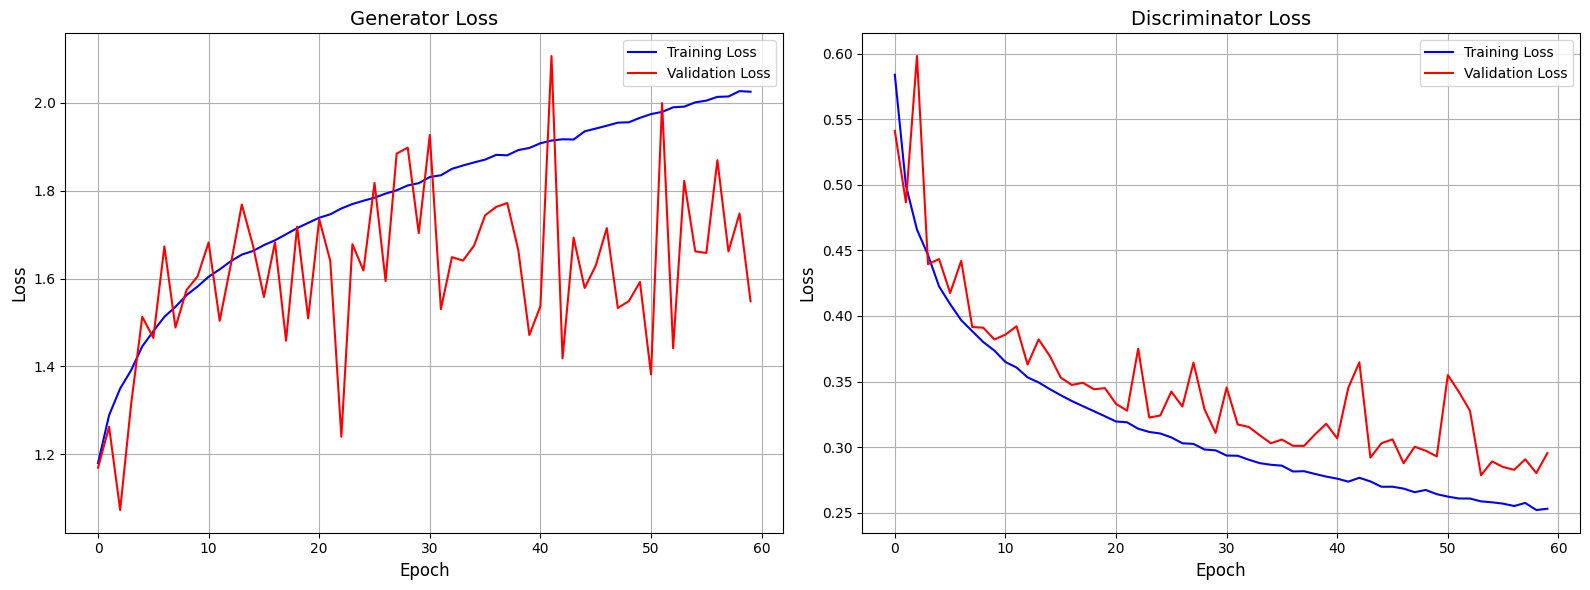

In [27]:
plt.figure(figsize=(16, 6))

# Subplot for Generator Loss
plt.subplot(1, 2, 1)
plt.plot(gen_train_losses, 'b-', label='Training Loss')
plt.plot(gen_val_losses, 'r-', label='Validation Loss')
plt.title('Generator Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Subplot for Discriminator Loss
plt.subplot(1, 2, 2)
plt.plot(disc_train_losses, 'b-', label='Training Loss')
plt.plot(disc_val_losses, 'r-', label='Validation Loss')
plt.title('Discriminator Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

### 7.2. Frechet Inception Distance (FID) and Inception Score (IS)

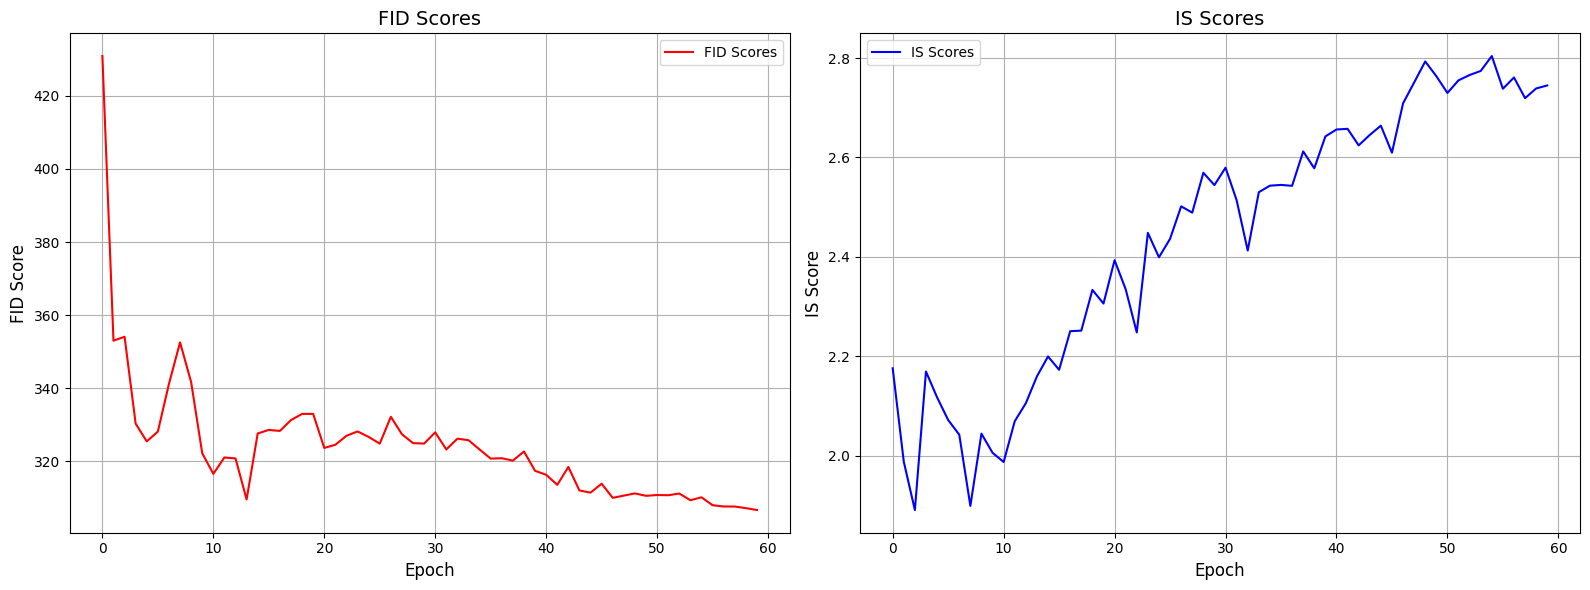

In [28]:
fid_scores_list = [score.item() if isinstance(score, torch.Tensor) else score for score in fid_scores]
is_scores_list = [score.item() if isinstance(score, torch.Tensor) else score for score in is_scores]

# plot biểu đồ
plt.figure(figsize=(16, 6))

# Subplot for FID Scores
plt.subplot(1, 2, 1)
plt.plot(fid_scores_list, 'r-', label='FID Scores')
plt.title('FID Scores', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('FID Score', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Subplot for IS Scores
plt.subplot(1, 2, 2)
plt.plot(is_scores_list, 'b-', label='IS Scores')
plt.title('IS Scores', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('IS Score', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

## 8. Generate image from caption

### 8.1. Load CLIP model

In [29]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
import clip
clip_model, clip_preprocess = clip.load('ViT-B/32', device=device)

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-m32onpb0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-m32onpb0
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... - done


### 8.2. Load trained GAN model 

In [30]:
gan.load_state_dict(torch.load('/kaggle/working/GAN_txt2img_model.pth'))
gan.eval()

GAN(
  (generator): Generator(
    (fc): Linear(in_features=512, out_features=100352, bias=True)
    (main): Sequential(
      (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): ResBlock(
        (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momen

### 8.3. Generate images

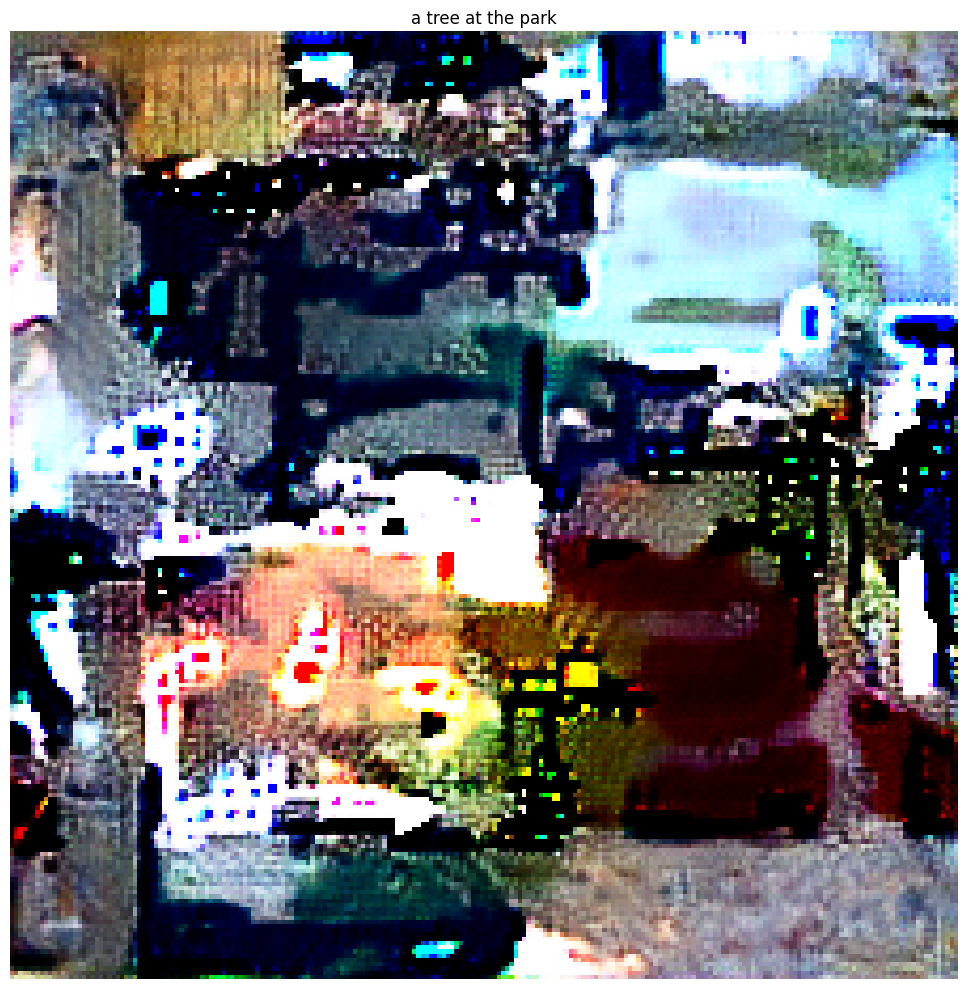

In [31]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

def generate_images(captions, num_images_per_caption=1):
    text_inputs = clip.tokenize(captions).to(device)
    text_embeddings = clip_model.encode_text(text_inputs)

    generated_images = []
    with torch.no_grad():
        for i in range(len(captions)):
            for _ in range(num_images_per_caption):
                fake_image = gan.generator(text_embeddings[i].unsqueeze(0))
                generated_images.append(fake_image)  
    return generated_images

output_dir = 'generated_images'
os.makedirs(output_dir, exist_ok=True)
captions = ["a tree at the park"]
num_images_per_caption = 1

generated_images = generate_images(captions, num_images_per_caption)  

num_rows = len(captions)
num_cols = num_images_per_caption
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))  
for i, img in enumerate(generated_images):
    img = img.squeeze(0).permute(1, 2, 0)
    img = img.detach().cpu().numpy()
    img = (img + 1) / 2  # Unnormalize ảnh

    if num_rows == 1 and num_cols == 1:
        axes.imshow(img)
        axes.set_title(captions[0]) 
        axes.axis('off')
    else:
        axes.ravel()[i].imshow(img)
        axes.ravel()[i].set_title(captions[i // num_cols]) 
        axes.ravel()[i].axis('off')

plt.tight_layout()
plt.show()


for i, img in enumerate(generated_images):
    save_image(img, os.path.join(output_dir, f'generated_image_{i}.png'))

In [32]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:         disc_lr ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: disc_train_loss █▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:   disc_val_loss █▇▅▅▅▄▄▄▃▄▃▃▃▃▂▃▂▃▃▂▃▂▂▁▁▁▂▂▃▁▂▁▁▁▃▂▁▁▁▁
wandb:       fid_score █▄▂▂▃▄▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
wandb:          gen_lr █████████▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
wandb:  gen_train_loss ▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████
wandb:    gen_val_loss ▁▂▂▄▅▄▅▅▅▆▄▅▆▄▅▂▅▆▇▇▇▄▅▅▆▆▄▄▃▅▅▆▄▅█▃▅▅▅▄
wandb:        is_score ▃▂▃▃▂▁▂▂▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▆▇█████▇▇█
wandb: 
wandb: Run summary:
wandb:         disc_lr 0.0001
wandb: disc_train_loss 0.25299
wandb:   disc_val_loss 0.29544
wandb:       fid_score 306.71231
wandb:          gen_lr 1e-05
wandb:  gen_train_loss 2.02554
wandb:    gen_val_loss 1.54821
wandb:        is_score 2.74486
wandb: 
wandb: 🚀 View run Running on Kaggle at: https://wandb.ai/tien-thanh-info22/GAN_text_to_ima